<a href="https://colab.research.google.com/github/rizz778/btp-project/blob/main/notebooks/supervised_comment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers torch scikit-learn pandas numpy matplotlib seaborn

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from transformers import (
    BertTokenizer,
    BertModel,

    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [19]:
class DataPreprocessor:
    """Handles data loading and preprocessing"""

    def __init__(self, data_path=None):
        self.data_path = data_path
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def load_data(self, df=None):
        """Load data from file or use provided DataFrame"""
        if df is not None:
            self.df = df.copy()
        elif self.data_path:
            self.df = pd.read_csv(self.data_path)
        else:
            # Create sample data for demonstration
            print("No data provided. Creating sample dataset...")
            self.df = self._create_sample_data()

        return self.df

    def _create_sample_data(self):
        """Create sample data for demonstration"""
        sample_comments = [
            "This product is amazing! Love it so much.",
            "Terrible quality, waste of money.",
            "It's okay, nothing special.",
            "Great customer service and fast delivery.",
            "Poor packaging, item arrived damaged.",
            "Neutral opinion about this item.",
            "Excellent value for money!",
            "Disappointing experience overall.",
            "Average product, meets expectations.",
            "Outstanding quality and design!"
        ] * 100  # Repeat to have more samples

        # Create labels
        topics = np.random.randint(0, 5, len(sample_comments))
        sentiments = np.random.choice([-1, 0, 1], len(sample_comments))

        return pd.DataFrame({
            'translated': sample_comments,
            'topic': topics,
            'sentiment': sentiments
        })

    def preprocess_data(self):
        """Preprocess the data according to requirements"""
        # Remap sentiment values: -1→0, 0→1, 1→2
        sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
        self.df['integrity'] = self.df['sentiment'].map(sentiment_mapping)

        # Print data distribution
        print("Data Distribution:")
        print(f"Total samples: {len(self.df)}")
        print(f"Topic distribution:\n{self.df['topic'].value_counts().sort_index()}")
        print(f"Integrity distribution:\n{self.df['integrity'].value_counts().sort_index()}")

        return self.df

    def split_data(self, test_size=0.2, random_state=42):
        """Split data into train and validation sets"""
        X = self.df['translated'].values
        y_topic = self.df['topic'].values
        y_integrity = self.df['integrity'].values

        # Split the data
        X_train, X_val, y_topic_train, y_topic_val, y_integrity_train, y_integrity_val = train_test_split(
            X, y_topic, y_integrity, test_size=test_size, random_state=random_state, stratify=y_topic
        )

        return (X_train, X_val, y_topic_train, y_topic_val, y_integrity_train, y_integrity_val)


In [5]:
class CommentDataset(Dataset):
    """Custom dataset for comment classification"""

    def __init__(self, texts, topic_labels, integrity_labels, tokenizer, max_length=128):
        self.texts = texts
        self.topic_labels = topic_labels
        self.integrity_labels = integrity_labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        topic_label = self.topic_labels[idx]
        integrity_label = self.integrity_labels[idx]

        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'topic_label': torch.tensor(topic_label, dtype=torch.long),
            'integrity_label': torch.tensor(integrity_label, dtype=torch.long)
        }

In [15]:
class DualTaskBERT(nn.Module):
    """Dual-head BERT model for topic and integrity classification"""

    def __init__(self, n_topic_classes=5, n_integrity_classes=3, dropout_prob=0.3):
        super(DualTaskBERT, self).__init__()

        # Shared BERT encoder
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_prob)

        # Classification heads
        self.topic_head = nn.Linear(self.bert.config.hidden_size, n_topic_classes)
        self.integrity_head = nn.Linear(self.bert.config.hidden_size, n_integrity_classes)

    def forward(self, input_ids, attention_mask):
        # Get BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Use [CLS] token representation
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)

        # Get predictions from both heads
        topic_logits = self.topic_head(pooled_output)
        integrity_logits = self.integrity_head(pooled_output)

        return topic_logits, integrity_logits, pooled_output


In [6]:
def compute_class_weights(labels, n_classes):
    """Compute class weights to handle imbalanced data"""
    try:
        unique_labels = np.unique(labels)
        if len(unique_labels) < n_classes:
            print(f"Warning: Only {len(unique_labels)} classes found in training data")
            return None

        weights = compute_class_weight(
            'balanced',
            classes=np.arange(n_classes),
            y=labels
        )
        return torch.FloatTensor(weights).to(device)
    except Exception as e:
        print(f"Could not compute class weights: {e}")
        return None

In [7]:
class CommentEmbeddingTrainer:
    """Main training class"""

    def __init__(self, model, train_loader, val_loader,
                 topic_weights=None, integrity_weights=None):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader

        # Loss functions
        self.topic_loss_fn = nn.CrossEntropyLoss(weight=topic_weights)
        self.integrity_loss_fn = nn.CrossEntropyLoss(weight=integrity_weights)

        # Training history
        self.train_losses = []
        self.topic_losses = []
        self.integrity_losses = []
        self.best_loss = float('inf')

    def setup_optimizer_scheduler(self, learning_rate=2e-5, weight_decay=0.01,
                                warmup_ratio=0.1, num_epochs=10):
        """Setup optimizer and scheduler"""
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )

        total_steps = len(self.train_loader) * num_epochs
        warmup_steps = int(total_steps * warmup_ratio)

        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        total_topic_loss = 0
        total_integrity_loss = 0

        progress_bar = tqdm(self.train_loader, desc="Training")

        for batch in progress_bar:
            # Move to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            topic_labels = batch['topic_label'].to(device)
            integrity_labels = batch['integrity_label'].to(device)

            # Forward pass
            topic_logits, integrity_logits, _ = self.model(input_ids, attention_mask)

            # Compute losses
            topic_loss = self.topic_loss_fn(topic_logits, topic_labels)
            integrity_loss = self.integrity_loss_fn(integrity_logits, integrity_labels)
            combined_loss = topic_loss + integrity_loss

            # Backward pass
            self.optimizer.zero_grad()
            combined_loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.optimizer.step()
            self.scheduler.step()

            # Track losses
            total_loss += combined_loss.item()
            total_topic_loss += topic_loss.item()
            total_integrity_loss += integrity_loss.item()

            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{combined_loss.item():.4f}',
                'Topic': f'{topic_loss.item():.4f}',
                'Integrity': f'{integrity_loss.item():.4f}'
            })

        avg_loss = total_loss / len(self.train_loader)
        avg_topic_loss = total_topic_loss / len(self.train_loader)
        avg_integrity_loss = total_integrity_loss / len(self.train_loader)

        return avg_loss, avg_topic_loss, avg_integrity_loss

    def train(self, num_epochs=10):
        """Full training loop"""
        print(f"Starting training for {num_epochs} epochs...")

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")

            # Train epoch
            train_loss, topic_loss, integrity_loss = self.train_epoch()

            # Track losses
            self.train_losses.append(train_loss)
            self.topic_losses.append(topic_loss)
            self.integrity_losses.append(integrity_loss)

            print(f"Average Losses - Total: {train_loss:.4f}, "
                  f"Topic: {topic_loss:.4f}, Integrity: {integrity_loss:.4f}")

            # Save best model
            if train_loss < self.best_loss:
                self.best_loss = train_loss
                torch.save(self.model.state_dict(), 'best_model.pt')
                print(f"New best model saved! Loss: {train_loss:.4f}")

    def plot_training_history(self):
        """Plot training losses"""
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.plot(self.train_losses)
        plt.title('Total Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.subplot(1, 3, 2)
        plt.plot(self.topic_losses)
        plt.title('Topic Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.subplot(1, 3, 3)
        plt.plot(self.integrity_losses)
        plt.title('Integrity Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.tight_layout()
        plt.show()


In [8]:
def evaluate_model(model, val_loader):
    """Evaluate model on validation set"""
    model.eval()

    all_topic_preds = []
    all_topic_labels = []
    all_integrity_preds = []
    all_integrity_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            topic_labels = batch['topic_label'].to(device)
            integrity_labels = batch['integrity_label'].to(device)

            # Forward pass
            topic_logits, integrity_logits, _ = model(input_ids, attention_mask)

            # Get predictions
            topic_preds = torch.argmax(topic_logits, dim=1)
            integrity_preds = torch.argmax(integrity_logits, dim=1)

            # Store results
            all_topic_preds.extend(topic_preds.cpu().numpy())
            all_topic_labels.extend(topic_labels.cpu().numpy())
            all_integrity_preds.extend(integrity_preds.cpu().numpy())
            all_integrity_labels.extend(integrity_labels.cpu().numpy())

    return (all_topic_preds, all_topic_labels,
            all_integrity_preds, all_integrity_labels)


In [9]:
def plot_confusion_matrices(topic_preds, topic_labels, integrity_preds, integrity_labels):
    """Plot confusion matrices for both tasks"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Topic confusion matrix
    topic_cm = confusion_matrix(topic_labels, topic_preds)
    sns.heatmap(topic_cm, annot=True, fmt='d', ax=axes[0], cmap='Blues')
    axes[0].set_title('Topic Classification Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Integrity confusion matrix
    integrity_cm = confusion_matrix(integrity_labels, integrity_preds)
    sns.heatmap(integrity_cm, annot=True, fmt='d', ax=axes[1], cmap='Greens')
    axes[1].set_title('Integrity Classification Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()


In [20]:
preprocessor = DataPreprocessor()
df = pd.read_csv('/content/revised_review_time.csv')  # Uncomment and use your data
preprocessor.load_data(df)

,Name,Review,sentiment_score,sentiment,topic,translated,review_time
0,Ayesha,First of all we should not pollute the sea/oce...,"{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...",positive,1,First of all we should not pollute the sea/oce...,2023-08-06
1,Gaurav Shirishbhai Gohel,ગણેશ વિસર્જન અને અન્ય ધાર્મિક મુર્તિઓ પ્લાસ્ટર...,"{'neg': 0.0, 'neu': 0.824, 'pos': 0.176, 'comp...",positive,1,Ganesh dissolution and other religious idols u...,2023-08-12
2,Gaurav Shirishbhai Gohel,ધાર્મિક કાર્યો માં વપરાતા ફૂલ હાર વગેરે દરિયામ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1,"Flowers used in religious activities, etc., sh...",2023-09-15
3,RohitThakur,"note: My suggestion is in the attachment, brie...","{'neg': 0.086, 'neu': 0.823, 'pos': 0.091, 'co...",negative,1,"note: My suggestion is in the attachment, brie...",2023-09-18
4,Dr Mamta Chaudhary,1)Ban plastic🛍 ❌2) segregate garbage properly ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1,1)Ban plastic🛍 ❌2) segregate garbage properly ...,2023-09-25
...,...,...,...,...,...,...,...
1840,Hemant Parikh,"Pets and animals ,should not be allowed on bea...","{'neg': 0.073, 'neu': 0.854, 'pos': 0.073, 'co...",neutral,1,"Pets and animals ,should not be allowed on bea...",2023-04-17
1841,Hemant Parikh,Beaches can be given to pvt contractors for it...,"{'neg': 0.0, 'neu': 0.932, 'pos': 0.068, 'comp...",positive,1,Beaches can be given to pvt contractors for it...,2023-07-06
1842,Hemant Parikh,Encourage uses of stp to treat waste of city r...,"{'neg': 0.105, 'neu': 0.744, 'pos': 0.152, 'co...",positive,1,Encourage uses of stp to treat waste of city r...,2023-10-07
1843,Ajinkya Rajendra Kolkar,Don’t smoke! Cigarette butts are the leading p...,"{'neg': 0.038, 'neu': 0.777, 'pos': 0.184, 'co...",positive,1,Don’t smoke! Cigarette butts are the leading p...,2023-03-24


In [21]:
preprocessor.preprocess_data()
X_train, X_val, y_topic_train, y_topic_val, y_integrity_train, y_integrity_val = preprocessor.split_data()

Data Distribution:
Total samples: 1845
Topic distribution:
topic
0      27
1    1706
2      43
3      41
4      28
Name: count, dtype: int64
Integrity distribution:
integrity
0     407
1     209
2    1229
Name: count, dtype: int64


In [22]:
print("\n📦 Step 2: Creating Dataset Loaders")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = CommentDataset(X_train, y_topic_train, y_integrity_train, tokenizer)
val_dataset = CommentDataset(X_val, y_topic_val, y_integrity_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


📦 Step 2: Creating Dataset Loaders


In [23]:
print("\n🏗️ Step 3: Initializing Model")
model = DualTaskBERT(n_topic_classes=5, n_integrity_classes=3)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


🏗️ Step 3: Initializing Model


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model parameters: 109,488,392


In [24]:
# 4. Compute class weights
print("\n⚖️ Step 4: Computing Class Weights")
topic_weights = compute_class_weights(y_topic_train, 5)
integrity_weights = compute_class_weights(y_integrity_train, 3)


⚖️ Step 4: Computing Class Weights


In [25]:
# 5. Setup trainer
print("\n🚀 Step 5: Setting up Trainer")
trainer = CommentEmbeddingTrainer(model, train_loader, val_loader,
                                    topic_weights, integrity_weights)
trainer.setup_optimizer_scheduler(num_epochs=10)



🚀 Step 5: Setting up Trainer


In [26]:
print("\n🔥 Step 6: Training Model")
trainer.train(num_epochs=10)


🔥 Step 6: Training Model
Starting training for 10 epochs...

Epoch 1/10


Training: 100%|██████████| 93/93 [00:33<00:00,  2.78it/s, Loss=2.6469, Topic=1.3317, Integrity=1.3153]


Average Losses - Total: 2.7343, Topic: 1.6537, Integrity: 1.0806
New best model saved! Loss: 2.7343

Epoch 2/10


Training: 100%|██████████| 93/93 [00:32<00:00,  2.86it/s, Loss=2.1357, Topic=0.9727, Integrity=1.1630]


Average Losses - Total: 2.1698, Topic: 1.2315, Integrity: 0.9383
New best model saved! Loss: 2.1698

Epoch 3/10


Training: 100%|██████████| 93/93 [00:32<00:00,  2.82it/s, Loss=1.2642, Topic=0.2472, Integrity=1.0170]


Average Losses - Total: 1.6211, Topic: 0.8514, Integrity: 0.7696
New best model saved! Loss: 1.6211

Epoch 4/10


Training: 100%|██████████| 93/93 [00:33<00:00,  2.78it/s, Loss=1.2925, Topic=0.7407, Integrity=0.5518]


Average Losses - Total: 1.1998, Topic: 0.6107, Integrity: 0.5891
New best model saved! Loss: 1.1998

Epoch 5/10


Training: 100%|██████████| 93/93 [00:33<00:00,  2.75it/s, Loss=0.4071, Topic=0.1760, Integrity=0.2311]


Average Losses - Total: 0.7927, Topic: 0.3818, Integrity: 0.4109
New best model saved! Loss: 0.7927

Epoch 6/10


Training: 100%|██████████| 93/93 [00:34<00:00,  2.71it/s, Loss=0.1194, Topic=0.0578, Integrity=0.0616]


Average Losses - Total: 0.5750, Topic: 0.2998, Integrity: 0.2752
New best model saved! Loss: 0.5750

Epoch 7/10


Training: 100%|██████████| 93/93 [00:34<00:00,  2.71it/s, Loss=0.6090, Topic=0.5578, Integrity=0.0512]


Average Losses - Total: 0.3979, Topic: 0.2015, Integrity: 0.1964
New best model saved! Loss: 0.3979

Epoch 8/10


Training: 100%|██████████| 93/93 [00:34<00:00,  2.70it/s, Loss=0.1581, Topic=0.0446, Integrity=0.1135]


Average Losses - Total: 0.2751, Topic: 0.1353, Integrity: 0.1398
New best model saved! Loss: 0.2751

Epoch 9/10


Training: 100%|██████████| 93/93 [00:34<00:00,  2.67it/s, Loss=0.0430, Topic=0.0207, Integrity=0.0223]


Average Losses - Total: 0.2243, Topic: 0.1071, Integrity: 0.1173
New best model saved! Loss: 0.2243

Epoch 10/10


Training: 100%|██████████| 93/93 [00:34<00:00,  2.66it/s, Loss=0.0327, Topic=0.0150, Integrity=0.0177]


Average Losses - Total: 0.1745, Topic: 0.0839, Integrity: 0.0906
New best model saved! Loss: 0.1745



📈 Step 7: Plotting Training History


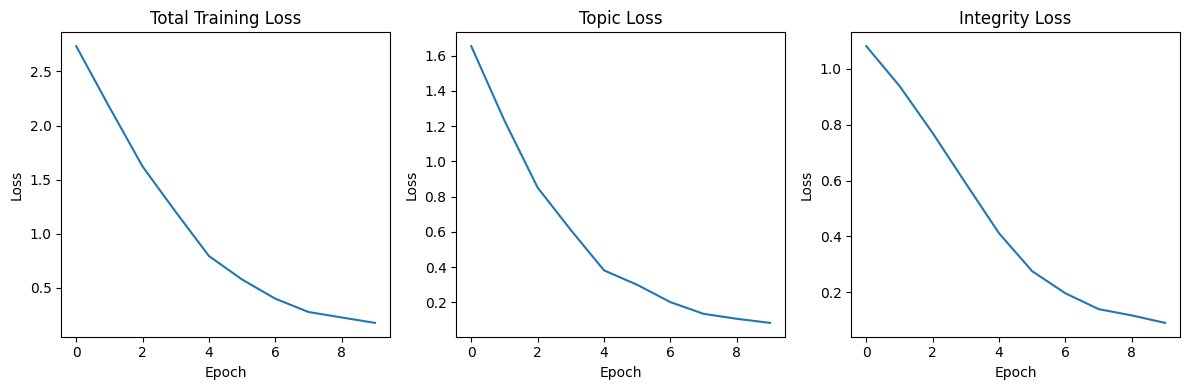

In [27]:
print("\n📈 Step 7: Plotting Training History")
trainer.plot_training_history()

In [29]:
model.load_state_dict(torch.load('best_model.pt'))
topic_preds, topic_labels, integrity_preds, integrity_labels = evaluate_model(model, val_loader)

Evaluating: 100%|██████████| 24/24 [00:02<00:00,  8.66it/s]


In [30]:
print("\n📋 Topic Classification Report:")
print(classification_report(topic_labels, topic_preds,
                              target_names=[f'Topic_{i}' for i in range(5)]))


📋 Topic Classification Report:
              precision    recall  f1-score   support

     Topic_0       0.60      0.60      0.60         5
     Topic_1       0.96      0.99      0.98       341
     Topic_2       0.80      0.44      0.57         9
     Topic_3       1.00      0.12      0.22         8
     Topic_4       1.00      1.00      1.00         6

    accuracy                           0.95       369
   macro avg       0.87      0.63      0.67       369
weighted avg       0.95      0.95      0.94       369



In [31]:
print("\n📋 Integrity Classification Report:")
print(classification_report(integrity_labels, integrity_preds,
                              target_names=['Negative', 'Neutral', 'Positive']))


📋 Integrity Classification Report:
              precision    recall  f1-score   support

    Negative       0.68      0.69      0.69        75
     Neutral       0.76      0.58      0.66        33
    Positive       0.90      0.92      0.91       261

    accuracy                           0.85       369
   macro avg       0.78      0.73      0.75       369
weighted avg       0.84      0.85      0.84       369



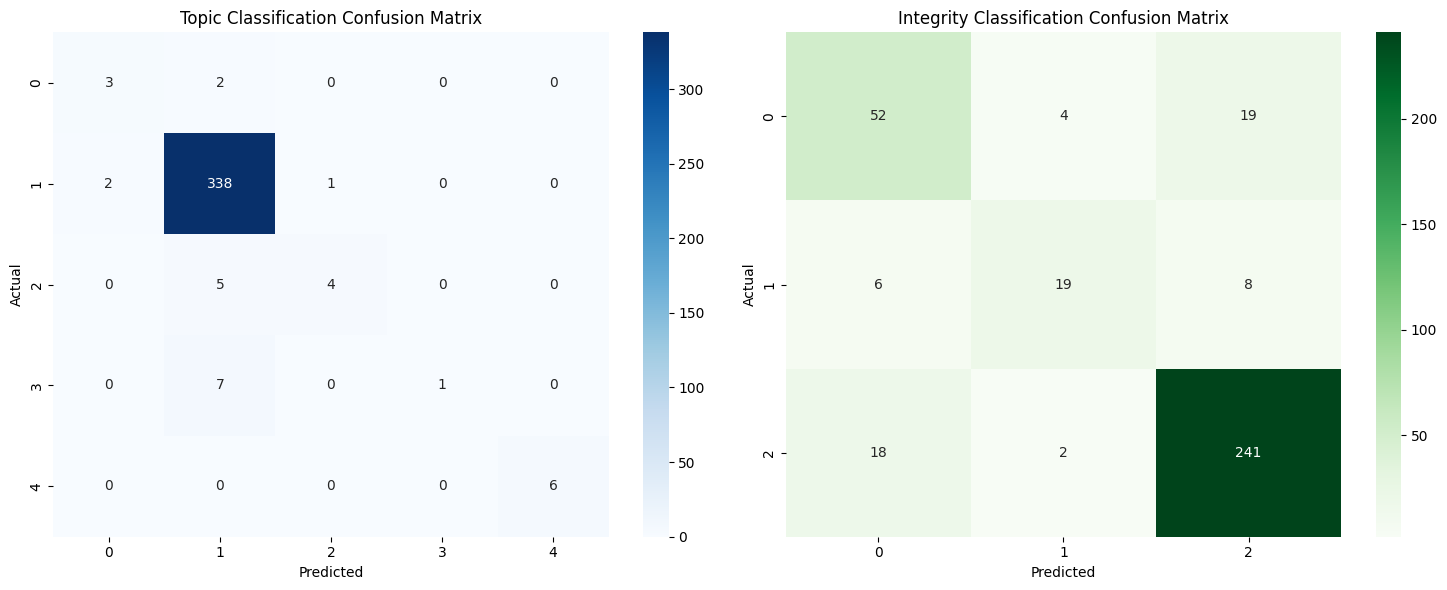

In [32]:
plot_confusion_matrices(topic_preds, topic_labels, integrity_preds, integrity_labels)

In [33]:
def extract_embeddings_example():
    """Example of how to extract embeddings for downstream tasks"""
    print("\n🎯 Example: Extracting Comment Embeddings")

    # Load trained model
    model = DualTaskBERT()
    model.load_state_dict(torch.load('best_model.pt'))
    model.eval()

    # Example comments
    comments=df['translated']

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    embeddings = []

    with torch.no_grad():
        for comment in comments:
            # Tokenize
            encoding = tokenizer(
                comment,
                truncation=True,
                padding='max_length',
                max_length=128,
                return_tensors='pt'
            )

            # Extract embedding
            _, _, embedding = model(encoding['input_ids'], encoding['attention_mask'])
            embeddings.append(embedding.numpy())

    embeddings = np.vstack(embeddings)
    print(f"Extracted embeddings shape: {embeddings.shape}")
    print("These embeddings can be aggregated with time-decay for user-level representations!")

In [34]:
extract_embeddings_example()


🎯 Example: Extracting Comment Embeddings
Extracted embeddings shape: (1845, 768)
These embeddings can be aggregated with time-decay for user-level representations!


# **EMBEDDING VISUALIZER**

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, adjusted_rand_score, silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import umap
from tqdm import tqdm

In [36]:
class EmbeddingAnalyzer:
    """Advanced analysis and visualization of comment embeddings"""

    def __init__(self, model, tokenizer, texts, topic_labels, integrity_labels):
        self.model = model
        self.tokenizer = tokenizer
        self.texts = np.array(texts)
        self.topic_labels = np.array(topic_labels)
        self.integrity_labels = np.array(integrity_labels)
        self.embeddings = None
        self.embeddings_3d_umap = None
        self.embeddings_3d_tsne = None

        # Label mappings for visualization
        self.topic_names = [f'Topic_{i}' for i in range(5)]
        self.integrity_names = ['Negative', 'Neutral', 'Positive']

    def extract_embeddings(self, batch_size=32):
        """Extract BERT [CLS] embeddings for all texts"""
        print("🔍 Extracting BERT embeddings...")

        self.model.eval()
        embeddings = []

        # Process in batches
        for i in tqdm(range(0, len(self.texts), batch_size)):
            batch_texts = self.texts[i:i+batch_size]

            # Tokenize batch
            encoded = self.tokenizer(
                batch_texts.tolist(),
                truncation=True,
                padding=True,
                max_length=128,
                return_tensors='pt'
            )

            # Extract embeddings
            with torch.no_grad():
                input_ids = encoded['input_ids'].to(device)
                attention_mask = encoded['attention_mask'].to(device)
                _, _, batch_embeddings = self.model(input_ids, attention_mask)
                embeddings.append(batch_embeddings.cpu().numpy())

        self.embeddings = np.vstack(embeddings)
        print(f"✅ Extracted embeddings shape: {self.embeddings.shape}")
        return self.embeddings

    def apply_dimensionality_reduction(self, method='both', n_neighbors=15, min_dist=0.1,
                                     perplexity=30, random_state=42):
        """Apply 3D dimensionality reduction using UMAP and/or t-SNE"""
        print(f"🔄 Applying 3D dimensionality reduction...")

        if method in ['umap', 'both']:
            print("   📊 Running UMAP...")
            umap_reducer = umap.UMAP(
                n_components=3,
                n_neighbors=n_neighbors,
                min_dist=min_dist,
                random_state=random_state,
                metric='cosine'
            )
            self.embeddings_3d_umap = umap_reducer.fit_transform(self.embeddings)
            print(f"   ✅ UMAP completed: {self.embeddings_3d_umap.shape}")

        if method in ['tsne', 'both']:
            print("   📊 Running t-SNE...")
            tsne_reducer = TSNE(
                n_components=3,
                perplexity=perplexity,
                random_state=random_state,
                n_iter=1000
            )
            self.embeddings_3d_tsne = tsne_reducer.fit_transform(self.embeddings)
            print(f"   ✅ t-SNE completed: {self.embeddings_3d_tsne.shape}")

        return self.embeddings_3d_umap, self.embeddings_3d_tsne

    def visualize_3d_embeddings(self, method='umap', sample_size=1000):
        """Create interactive 3D visualization using Plotly"""
        print(f"🎨 Creating 3D visualization with {method.upper()}...")

        # Select embedding method
        if method == 'umap' and self.embeddings_3d_umap is not None:
            embeddings_3d = self.embeddings_3d_umap
        elif method == 'tsne' and self.embeddings_3d_tsne is not None:
            embeddings_3d = self.embeddings_3d_tsne
        else:
            raise ValueError(f"3D embeddings for {method} not available. Run apply_dimensionality_reduction first.")

        # Sample data if too large
        if len(embeddings_3d) > sample_size:
            indices = np.random.choice(len(embeddings_3d), sample_size, replace=False)
            embeddings_3d = embeddings_3d[indices]
            topic_labels = self.topic_labels[indices]
            integrity_labels = self.integrity_labels[indices]
            texts = self.texts[indices]
        else:
            topic_labels = self.topic_labels
            integrity_labels = self.integrity_labels
            texts = self.texts

        # Create subplots
        fig = make_subplots(
            rows=1, cols=2,
            specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
            subplot_titles=[f'3D {method.upper()} - Topic Labels', f'3D {method.upper()} - Integrity Labels'],
            horizontal_spacing=0.1
        )

        # Topic visualization
        topic_colors = px.colors.qualitative.Set1[:5]
        for i in range(5):
            mask = topic_labels == i
            if np.any(mask):
                fig.add_trace(
                    go.Scatter3d(
                        x=embeddings_3d[mask, 0],
                        y=embeddings_3d[mask, 1],
                        z=embeddings_3d[mask, 2],
                        mode='markers',
                        marker=dict(size=4, color=topic_colors[i], opacity=0.7),
                        name=f'Topic {i}',
                        text=[f"Topic {i}<br>Text: {text[:100]}..." for text in texts[mask]],
                        hovertemplate="<b>%{fullData.name}</b><br>%{text}<extra></extra>"
                    ),
                    row=1, col=1
                )

        # Integrity visualization
        integrity_colors = ['red', 'gray', 'green']
        for i in range(3):
            mask = integrity_labels == i
            if np.any(mask):
                fig.add_trace(
                    go.Scatter3d(
                        x=embeddings_3d[mask, 0],
                        y=embeddings_3d[mask, 1],
                        z=embeddings_3d[mask, 2],
                        mode='markers',
                        marker=dict(size=4, color=integrity_colors[i], opacity=0.7),
                        name=self.integrity_names[i],
                        text=[f"{self.integrity_names[i]}<br>Text: {text[:100]}..." for text in texts[mask]],
                        hovertemplate="<b>%{fullData.name}</b><br>%{text}<extra></extra>",
                        showlegend=False
                    ),
                    row=1, col=2
                )

        # Update layout
        fig.update_layout(
            title=f'3D Comment Embeddings Visualization ({method.upper()})',
            height=600,
            showlegend=True,
            scene=dict(
                xaxis_title=f'{method.upper()} 1',
                yaxis_title=f'{method.upper()} 2',
                zaxis_title=f'{method.upper()} 3'
            ),
            scene2=dict(
                xaxis_title=f'{method.upper()} 1',
                yaxis_title=f'{method.upper()} 2',
                zaxis_title=f'{method.upper()} 3'
            )
        )

        fig.show()
        return fig

    def generate_similarity_heatmap(self, sample_size=50, metric='cosine'):
        """Generate similarity heatmap for random subset of embeddings"""
        print(f"🔥 Generating similarity heatmap for {sample_size} samples...")

        # Random sample
        indices = np.random.choice(len(self.embeddings), sample_size, replace=False)
        sample_embeddings = self.embeddings[indices]
        sample_texts = self.texts[indices]
        sample_topics = self.topic_labels[indices]
        sample_integrity = self.integrity_labels[indices]

        # Compute similarity matrix
        if metric == 'cosine':
            similarity_matrix = cosine_similarity(sample_embeddings)
        else:
            raise ValueError("Only cosine similarity is currently supported")

        # Create labels for heatmap
        labels = [f"T{topic}_I{integrity}" for topic, integrity in zip(sample_topics, sample_integrity)]

        # Create heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            similarity_matrix,
            xticklabels=labels,
            yticklabels=labels,
            cmap='viridis',
            center=0,
            square=True,
            fmt='.2f'
        )
        plt.title(f'Comment Embedding Similarity Heatmap ({metric.title()})\nT=Topic, I=Integrity')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        return similarity_matrix, sample_texts, labels

    def perform_clustering(self, methods=['kmeans', 'dbscan'], n_clusters=8, eps=0.5, min_samples=5):
        """Perform unsupervised clustering on embeddings"""
        print("🎯 Performing unsupervised clustering...")

        clustering_results = {}

        if 'kmeans' in methods:
            print("   📊 Running K-Means clustering...")
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            kmeans_labels = kmeans.fit_predict(self.embeddings)
            clustering_results['kmeans'] = {
                'labels': kmeans_labels,
                'model': kmeans,
                'silhouette': silhouette_score(self.embeddings, kmeans_labels)
            }
            print(f"   ✅ K-Means completed. Silhouette score: {clustering_results['kmeans']['silhouette']:.3f}")

        if 'dbscan' in methods:
            print("   📊 Running DBSCAN clustering...")
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
            dbscan_labels = dbscan.fit_predict(self.embeddings)
            n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
            n_noise = list(dbscan_labels).count(-1)

            clustering_results['dbscan'] = {
                'labels': dbscan_labels,
                'model': dbscan,
                'n_clusters': n_clusters_dbscan,
                'n_noise': n_noise
            }

            if n_clusters_dbscan > 1:
                # Only compute silhouette if we have more than 1 cluster
                mask = dbscan_labels != -1  # Exclude noise points
                if np.sum(mask) > 1:
                    clustering_results['dbscan']['silhouette'] = silhouette_score(
                        self.embeddings[mask], dbscan_labels[mask]
                    )
                else:
                    clustering_results['dbscan']['silhouette'] = -1
            else:
                clustering_results['dbscan']['silhouette'] = -1

            print(f"   ✅ DBSCAN completed. Clusters: {n_clusters_dbscan}, Noise points: {n_noise}")
            if clustering_results['dbscan']['silhouette'] > -1:
                print(f"      Silhouette score: {clustering_results['dbscan']['silhouette']:.3f}")

        return clustering_results

    def evaluate_clustering_alignment(self, clustering_results):
        """Evaluate how well clusters align with true labels"""
        print("📊 Evaluating clustering alignment with true labels...")

        evaluation_results = {}

        for method, results in clustering_results.items():
            cluster_labels = results['labels']

            # Topic alignment
            topic_ari = adjusted_rand_score(self.topic_labels, cluster_labels)

            # Integrity alignment
            integrity_ari = adjusted_rand_score(self.integrity_labels, cluster_labels)

            evaluation_results[method] = {
                'topic_ari': topic_ari,
                'integrity_ari': integrity_ari,
                'silhouette': results.get('silhouette', -1)
            }

            print(f"   🎯 {method.upper()}:")
            print(f"      Topic ARI: {topic_ari:.3f}")
            print(f"      Integrity ARI: {integrity_ari:.3f}")
            if results.get('silhouette', -1) > -1:
                print(f"      Silhouette: {results['silhouette']:.3f}")

        return evaluation_results

    def visualize_clustering_results(self, clustering_results, method='umap'):
        """Visualize clustering results in 3D"""
        print(f"🎨 Visualizing clustering results...")

        # Select embedding method
        if method == 'umap' and self.embeddings_3d_umap is not None:
            embeddings_3d = self.embeddings_3d_umap
        elif method == 'tsne' and self.embeddings_3d_tsne is not None:
            embeddings_3d = self.embeddings_3d_tsne
        else:
            raise ValueError(f"3D embeddings for {method} not available.")

        n_methods = len(clustering_results)
        fig = make_subplots(
            rows=1, cols=n_methods,
            specs=[[{'type': 'scatter3d'} for _ in range(n_methods)]],
            subplot_titles=[f'{method.upper()} Clustering' for method in clustering_results.keys()],
            horizontal_spacing=0.1
        )

        col = 1
        for cluster_method, results in clustering_results.items():
            cluster_labels = results['labels']
            unique_labels = np.unique(cluster_labels)

            # Color palette
            colors = px.colors.qualitative.Set3

            for i, label in enumerate(unique_labels):
                mask = cluster_labels == label
                color = colors[i % len(colors)] if label != -1 else 'black'
                name = f'Cluster {label}' if label != -1 else 'Noise'

                fig.add_trace(
                    go.Scatter3d(
                        x=embeddings_3d[mask, 0],
                        y=embeddings_3d[mask, 1],
                        z=embeddings_3d[mask, 2],
                        mode='markers',
                        marker=dict(size=4, color=color, opacity=0.7),
                        name=name,
                        showlegend=(col == 1)  # Only show legend for first subplot
                    ),
                    row=1, col=col
                )

            col += 1

        fig.update_layout(
            title='Clustering Results Visualization',
            height=600
        )

        fig.show()
        return fig

    def generate_cluster_analysis_report(self, clustering_results, evaluation_results):
        """Generate comprehensive clustering analysis report"""
        print("\n" + "="*60)
        print("📋 CLUSTERING ANALYSIS REPORT")
        print("="*60)

        for method in clustering_results.keys():
            print(f"\n🎯 {method.upper()} CLUSTERING:")
            print("-" * 30)

            cluster_labels = clustering_results[method]['labels']
            unique_clusters = np.unique(cluster_labels)

            print(f"Number of clusters: {len(unique_clusters)}")
            if method == 'dbscan':
                n_noise = clustering_results[method]['n_noise']
                print(f"Noise points: {n_noise} ({n_noise/len(cluster_labels)*100:.1f}%)")

            print(f"Silhouette Score: {evaluation_results[method]['silhouette']:.3f}")
            print(f"Topic Alignment (ARI): {evaluation_results[method]['topic_ari']:.3f}")
            print(f"Integrity Alignment (ARI): {evaluation_results[method]['integrity_ari']:.3f}")

            # Cluster size distribution
            cluster_sizes = []
            for cluster_id in unique_clusters:
                size = np.sum(cluster_labels == cluster_id)
                cluster_sizes.append(size)

            print(f"Cluster sizes: {cluster_sizes}")
            print(f"Average cluster size: {np.mean(cluster_sizes):.1f}")
            print(f"Cluster size std: {np.std(cluster_sizes):.1f}")

        print("\n" + "="*60)

    def run_complete_analysis(self, sample_size=1000):
        """Run complete embedding analysis pipeline"""
        print("🚀 Running Complete Embedding Analysis Pipeline")
        print("="*60)

        # 1. Extract embeddings
        self.extract_embeddings()

        # 2. Apply dimensionality reduction
        self.apply_dimensionality_reduction(method='both')

        # 3. Visualize 3D embeddings
        print("\n📊 Creating 3D visualizations...")
        self.visualize_3d_embeddings('umap', sample_size)
        self.visualize_3d_embeddings('tsne', sample_size)

        # 4. Generate similarity heatmap
        self.generate_similarity_heatmap(sample_size=min(50, sample_size))

        # 5. Perform clustering
        clustering_results = self.perform_clustering()

        # 6. Evaluate clustering
        evaluation_results = self.evaluate_clustering_alignment(clustering_results)

        # 7. Visualize clustering results
        self.visualize_clustering_results(clustering_results, 'umap')

        # 8. Generate report
        self.generate_cluster_analysis_report(clustering_results, evaluation_results)

        return {
            'embeddings': self.embeddings,
            'embeddings_3d_umap': self.embeddings_3d_umap,
            'embeddings_3d_tsne': self.embeddings_3d_tsne,
            'clustering_results': clustering_results,
            'evaluation_results': evaluation_results
        }


In [37]:
def evaluate_model(model, val_loader):
    """Evaluate model on validation set"""
    model.eval()

    all_topic_preds = []
    all_topic_labels = []
    all_integrity_preds = []
    all_integrity_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            topic_labels = batch['topic_label'].to(device)
            integrity_labels = batch['integrity_label'].to(device)

            # Forward pass
            topic_logits, integrity_logits, _ = model(input_ids, attention_mask)

            # Get predictions
            topic_preds = torch.argmax(topic_logits, dim=1)
            integrity_preds = torch.argmax(integrity_logits, dim=1)

            # Store results
            all_topic_preds.extend(topic_preds.cpu().numpy())
            all_topic_labels.extend(topic_labels.cpu().numpy())
            all_integrity_preds.extend(integrity_preds.cpu().numpy())
            all_integrity_labels.extend(integrity_labels.cpu().numpy())

    return (all_topic_preds, all_topic_labels,
            all_integrity_preds, all_integrity_labels)

In [38]:
def plot_confusion_matrices(topic_preds, topic_labels, integrity_preds, integrity_labels):
    """Plot confusion matrices for both tasks"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Topic confusion matrix
    topic_cm = confusion_matrix(topic_labels, topic_preds)
    sns.heatmap(topic_cm, annot=True, fmt='d', ax=axes[0], cmap='Blues')
    axes[0].set_title('Topic Classification Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Integrity confusion matrix
    integrity_cm = confusion_matrix(integrity_labels, integrity_preds)
    sns.heatmap(integrity_cm, annot=True, fmt='d', ax=axes[1], cmap='Greens')
    axes[1].set_title('Integrity Classification Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

🚀 Running Complete Embedding Analysis Pipeline
🔍 Extracting BERT embeddings...


100%|██████████| 58/58 [00:13<00:00,  4.40it/s]


✅ Extracted embeddings shape: (1845, 768)
🔄 Applying 3D dimensionality reduction...
   📊 Running UMAP...
   ✅ UMAP completed: (1845, 3)
   📊 Running t-SNE...
   ✅ t-SNE completed: (1845, 3)

📊 Creating 3D visualizations...
🎨 Creating 3D visualization with UMAP...


🎨 Creating 3D visualization with TSNE...


🔥 Generating similarity heatmap for 50 samples...


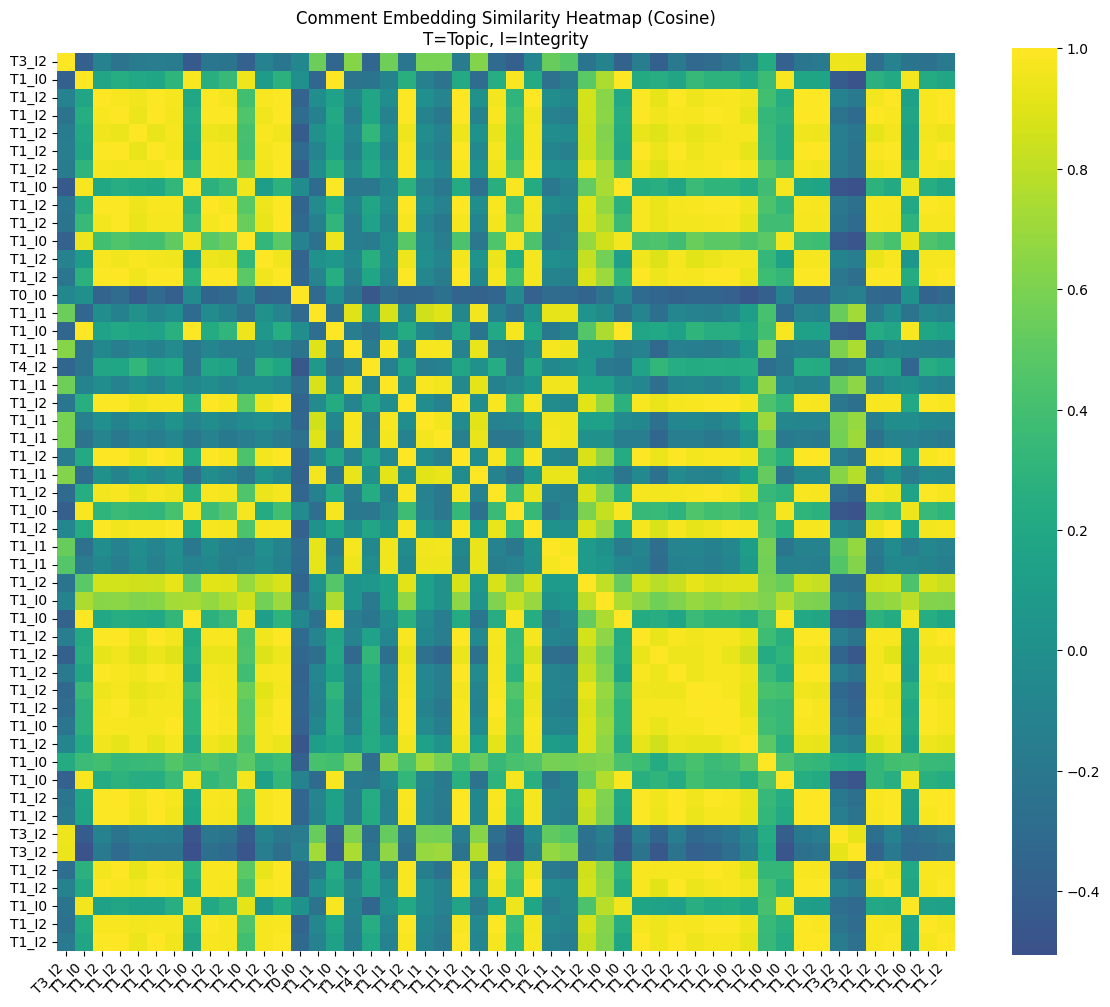

🎯 Performing unsupervised clustering...
   📊 Running K-Means clustering...
   ✅ K-Means completed. Silhouette score: 0.550
   📊 Running DBSCAN clustering...
   ✅ DBSCAN completed. Clusters: 1, Noise points: 0
📊 Evaluating clustering alignment with true labels...
   🎯 KMEANS:
      Topic ARI: 0.170
      Integrity ARI: 0.710
      Silhouette: 0.550
   🎯 DBSCAN:
      Topic ARI: 0.000
      Integrity ARI: 0.000
🎨 Visualizing clustering results...



📋 CLUSTERING ANALYSIS REPORT

🎯 KMEANS CLUSTERING:
------------------------------
Number of clusters: 8
Silhouette Score: 0.550
Topic Alignment (ARI): 0.170
Integrity Alignment (ARI): 0.710
Cluster sizes: [np.int64(88), np.int64(190), np.int64(369), np.int64(40), np.int64(28), np.int64(1071), np.int64(25), np.int64(34)]
Average cluster size: 230.6
Cluster size std: 336.5

🎯 DBSCAN CLUSTERING:
------------------------------
Number of clusters: 1
Noise points: 0 (0.0%)
Silhouette Score: -1.000
Topic Alignment (ARI): 0.000
Integrity Alignment (ARI): 0.000
Cluster sizes: [np.int64(1845)]
Average cluster size: 1845.0
Cluster size std: 0.0



In [39]:
all_texts = np.concatenate([X_train, X_val])
all_topic_labels = np.concatenate([y_topic_train, y_topic_val])
all_integrity_labels = np.concatenate([y_integrity_train, y_integrity_val])

    # Initialize analyzer

analyzer = EmbeddingAnalyzer(
        model=model,
        tokenizer=tokenizer,
        texts=all_texts,
        topic_labels=all_topic_labels,
        integrity_labels=all_integrity_labels
    )

    # Run complete analysis
analysis_results = analyzer.run_complete_analysis(sample_size=1000)


In [41]:
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 30.0 MB/s eta 0:00:00


In [43]:
import faiss
# ✅ FAISS Part
dim = 768  # usually 768 for BERT
index = faiss.IndexFlatL2(dim)  # or use IndexFlatIP for cosine similarity (normalize first)index.add(self.embeddings)

    # Save the index to disk
faiss.write_index(index, "bert_comment_index.faiss")
print("✅ FAISS index saved as 'bert_comment_index.faiss'")

✅ FAISS index saved as 'bert_comment_index.faiss'


In [44]:
from google.colab import files
files.download("/content/best_model.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>